In [13]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"


In [14]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2020-10-08 20:47:34--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar’

postgresql-42.2.9.j 100%[===================>] 892.61K  1.41MB/s    in 0.6s    

2020-10-08 20:47:35 (1.41 MB/s) - ‘postgresql-42.2.9.jar’ saved [914037/914037]



In [15]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [16]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7637783221339136165, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9428150631626761791
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2814311058903415167
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14640891840
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16722622791837343830
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [21]:
#import boto
import pandas as pd
# Load in user_data.csv from S3 into a DataFrame
url = "https://capstonemusic.s3.amazonaws.com/data.csv"

data = pd.read_csv(url)
data = data.drop(columns=['filename'])
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596748,121.557297,-19.158825,42.351032,-6.376458,18.618876,-13.697911,15.344631,-12.285267,10.980492,-8.324325,8.810669,-3.667368,5.751691,-5.162763,0.750948,-1.691938,-0.409953,-2.300209,1.219929,blues
1,0.340983,0.130225,1529.835316,2038.617579,3548.820207,0.056044,-207.556793,124.006721,8.930560,35.874687,2.916037,21.523726,-8.554704,23.358671,-10.103617,11.903745,-5.560388,5.376803,-2.239120,4.216963,-6.012273,0.936110,-0.716537,0.293876,-0.287431,0.531573,blues
2,0.363603,0.095918,1552.481958,1747.165985,3040.514948,0.076301,-90.754387,140.459900,-29.109968,31.689013,-13.987036,25.754759,-13.649585,11.629271,-11.780589,9.706442,-13.123111,5.789265,-8.905224,-1.083720,-9.218359,2.455806,-7.726901,-1.815723,-3.433434,-2.226821,blues
3,0.404779,0.175573,1070.119953,1596.333948,2185.028454,0.033309,-199.431152,150.099213,5.647593,26.871927,1.754462,14.238345,-4.830883,9.297966,-0.757742,8.149013,-3.196314,6.087677,-2.476421,-1.073890,-2.874778,0.780977,-3.316932,0.637982,-0.619690,-3.408233,blues
4,0.308590,0.141191,1835.494603,1748.362448,3580.945013,0.101500,-160.266037,126.198807,-35.605450,22.153301,-32.489269,10.864513,-23.357929,0.503118,-11.805833,1.206805,-13.083821,-2.806384,-6.934123,-7.558618,-9.173553,-4.512165,-5.453538,-0.924161,-4.409333,-11.703781,blues


In [22]:
%matplotlib inline
import itertools
import numpy, scipy, matplotlib.pyplot as plt, pandas, librosa,sklearn

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

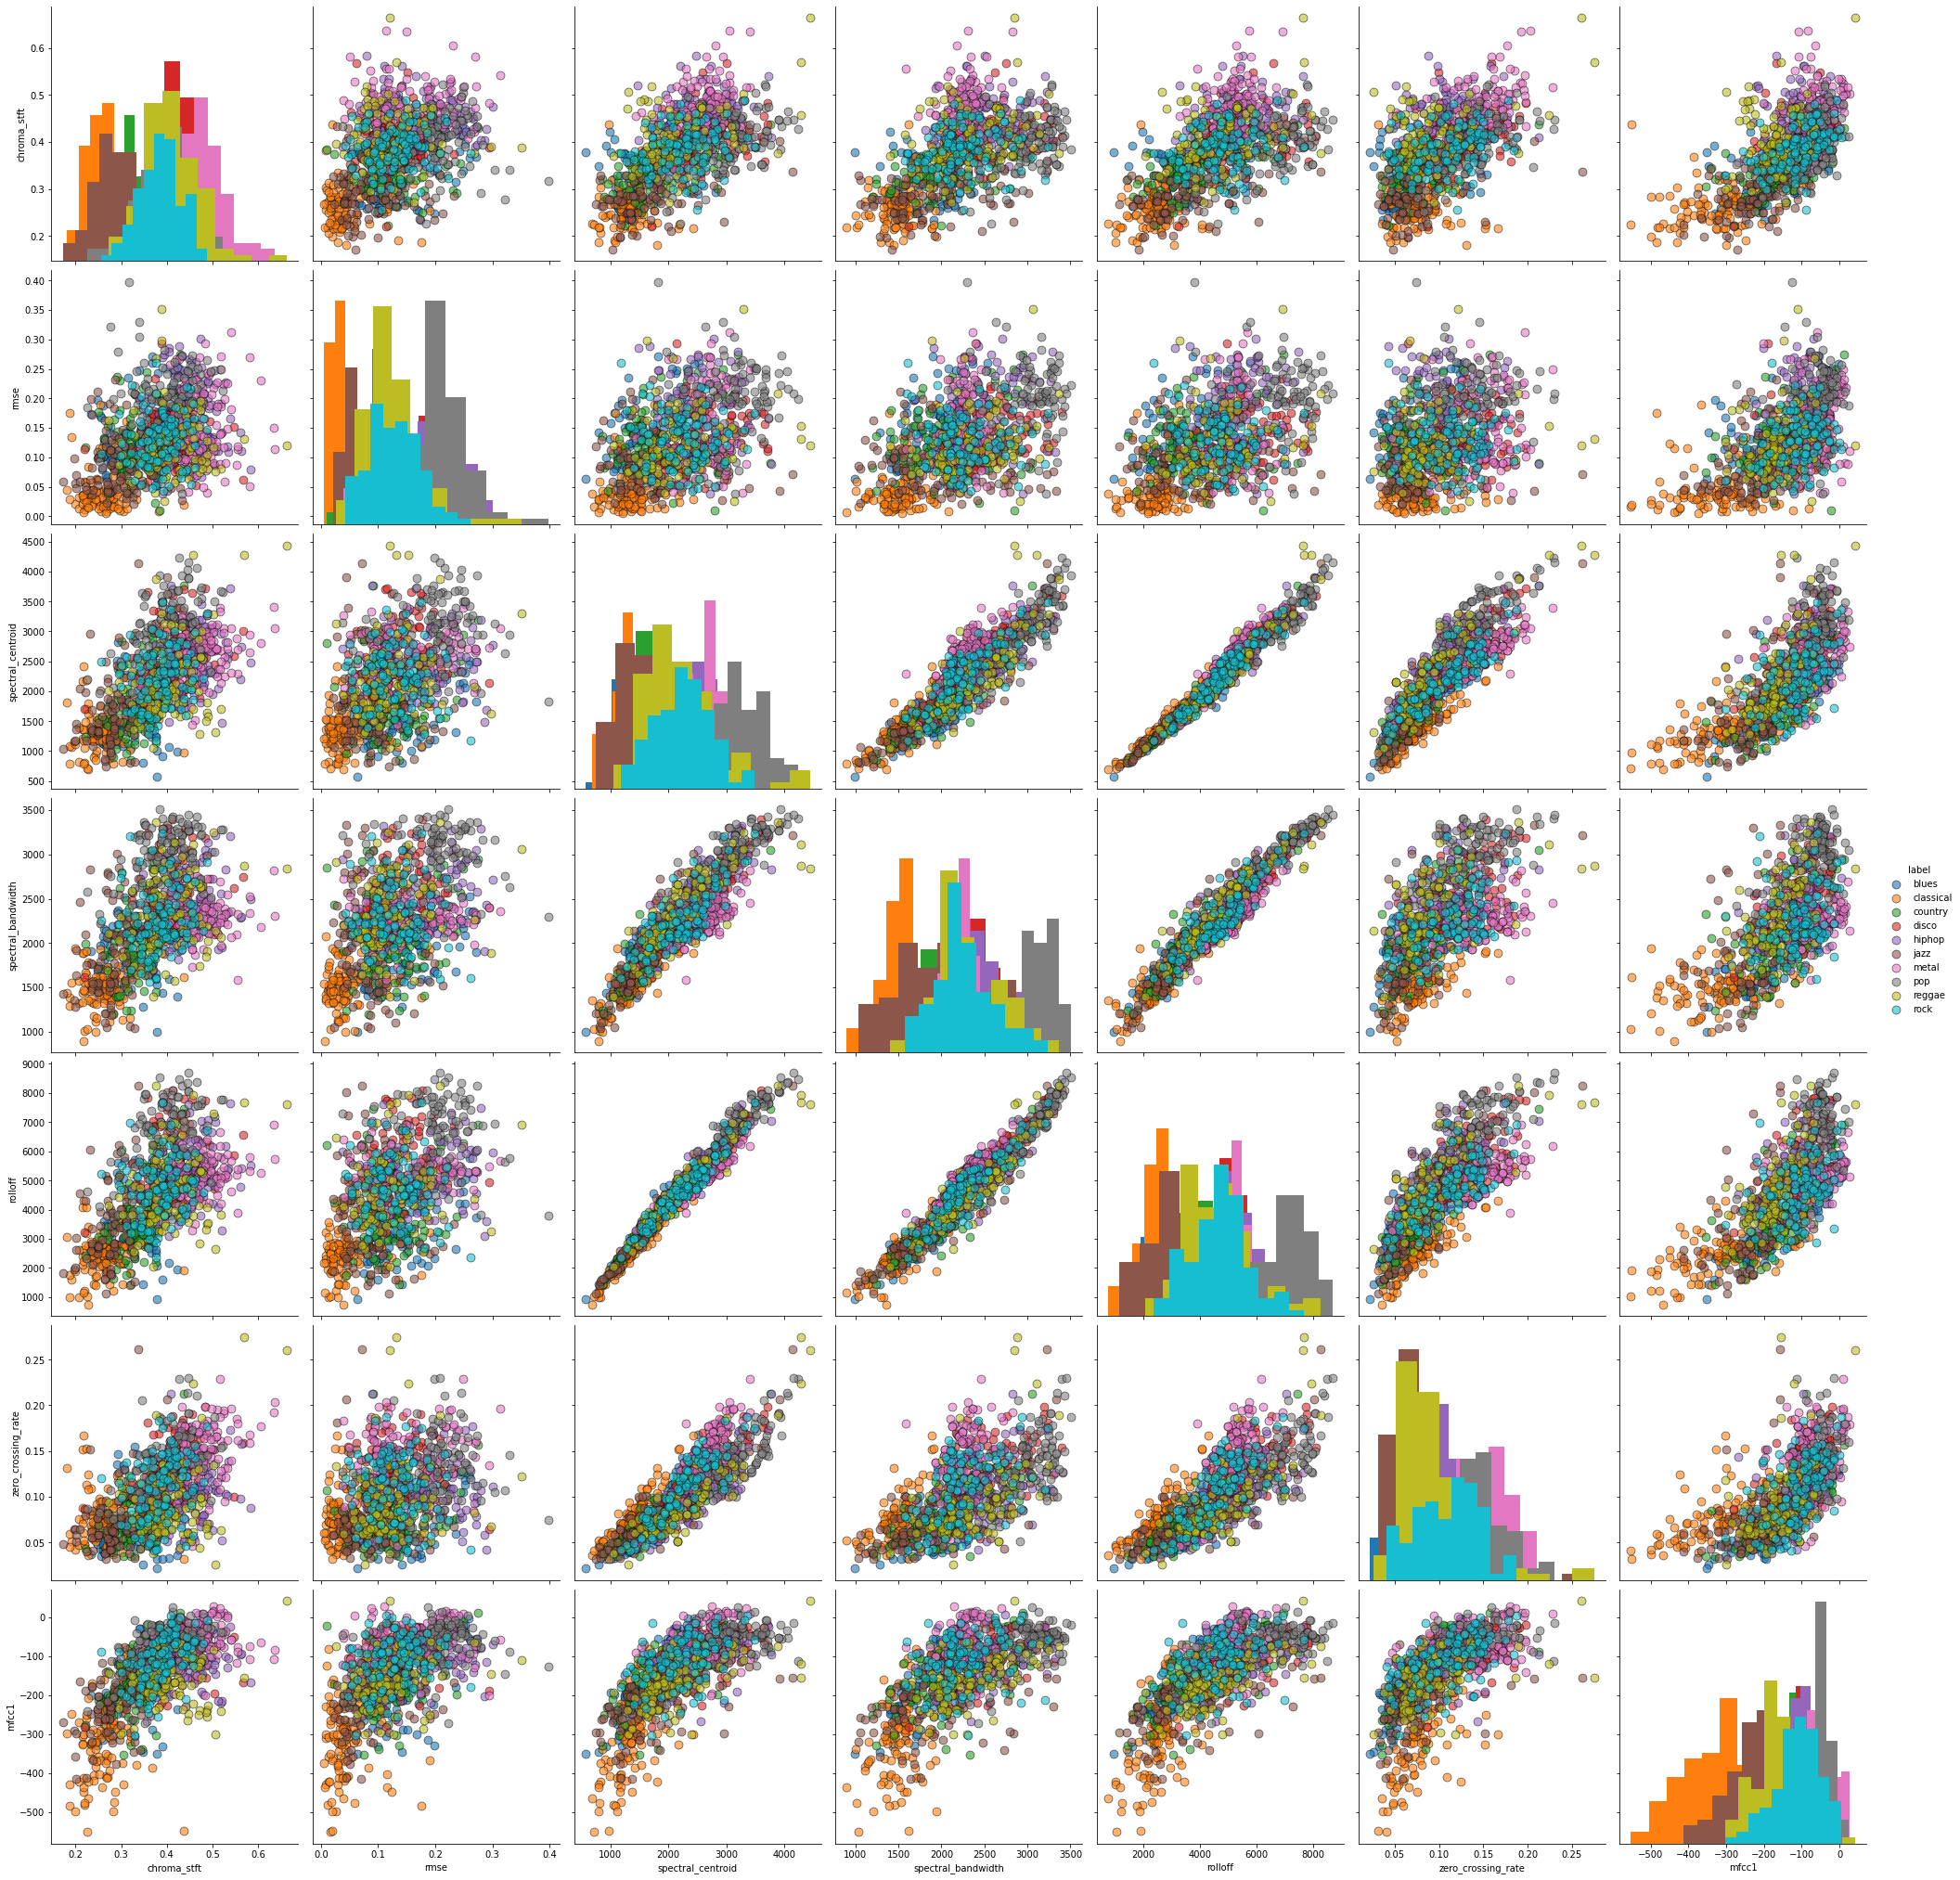

In [ ]:
#Exploratory data analysis
#Display thro pair plot the remationship between the features. Here only 8 features used to to limit the time taken to build the charts
plt1 = sns.pairplot(data , vars = ['chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
       'rolloff', 'zero_crossing_rate', 'mfcc1'], 
             hue = 'label', diag_kind = 'hist', 
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             height = 4)
plt1.savefig( 'pairplotMG.png')

In [23]:
#Check for data types if they are numeric
data.dtypes
# Other than filename and label all other features are numeric

chroma_stft           float64
rmse                  float64
spectral_centroid     float64
spectral_bandwidth    float64
rolloff               float64
zero_crossing_rate    float64
mfcc1                 float64
mfcc2                 float64
mfcc3                 float64
mfcc4                 float64
mfcc5                 float64
mfcc6                 float64
mfcc7                 float64
mfcc8                 float64
mfcc9                 float64
mfcc10                float64
mfcc11                float64
mfcc12                float64
mfcc13                float64
mfcc14                float64
mfcc15                float64
mfcc16                float64
mfcc17                float64
mfcc18                float64
mfcc19                float64
mfcc20                float64
label                  object
dtype: object

In [24]:
#We will ignore the categorical feature and consider only numeric ones.
yval, data_label= pd.factorize( data.label)
#data1 = data.replace({'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9})
features= data.columns[1:26]
y = data.label
x = data[features]
x

,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596748,121.557297,-19.158825,42.351032,-6.376458,18.618876,-13.697911,15.344631,-12.285267,10.980492,-8.324325,8.810669,-3.667368,5.751691,-5.162763,0.750948,-1.691938,-0.409953,-2.300209,1.219929
1,0.130225,1529.835316,2038.617579,3548.820207,0.056044,-207.556793,124.006721,8.930560,35.874687,2.916037,21.523726,-8.554704,23.358671,-10.103617,11.903745,-5.560388,5.376803,-2.239120,4.216963,-6.012273,0.936110,-0.716537,0.293876,-0.287431,0.531573
2,0.095918,1552.481958,1747.165985,3040.514948,0.076301,-90.754387,140.459900,-29.109968,31.689013,-13.987036,25.754759,-13.649585,11.629271,-11.780589,9.706442,-13.123111,5.789265,-8.905224,-1.083720,-9.218359,2.455806,-7.726901,-1.815723,-3.433434,-2.226821
3,0.175573,1070.119953,1596.333948,2185.028454,0.033309,-199.431152,150.099213,5.647593,26.871927,1.754462,14.238345,-4.830883,9.297966,-0.757742,8.149013,-3.196314,6.087677,-2.476421,-1.073890,-2.874778,0.780977,-3.316932,0.637982,-0.619690,-3.408233
4,0.141191,1835.494603,1748.362448,3580.945013,0.101500,-160.266037,126.198807,-35.605450,22.153301,-32.489269,10.864513,-23.357929,0.503118,-11.805833,1.206805,-13.083821,-2.806384,-6.934123,-7.558618,-9.173553,-4.512165,-5.453538,-0.924161,-4.409333,-11.703781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.101979,2008.581132,2106.617024,4254.215942,0.089267,-153.632309,109.857262,-23.085709,59.040676,-7.490499,19.731215,-16.481268,18.078421,-22.209015,15.402501,-12.380283,12.350817,-12.306271,5.780973,-10.279924,1.791489,-13.304210,2.473193,-6.717574,-1.189238
996,0.079469,2006.051164,2068.327905,4147.374921,0.097659,-142.424210,116.219780,-32.177074,49.122974,-8.375370,22.869043,-18.311548,20.091076,-22.100395,10.800343,-12.982494,14.065347,-16.394691,4.152589,-4.350760,3.736455,-10.845638,1.875218,-7.459579,-2.802677
997,0.076452,2077.190361,1926.989678,4030.767293,0.121824,-125.031326,115.194977,-47.993507,52.834534,-13.480977,21.755636,-12.418755,20.130632,-18.361841,10.113327,-16.048916,10.481962,-17.951916,1.211113,-11.534864,1.844774,-12.847901,3.447425,-12.594178,-2.107002
998,0.081617,1398.672358,1818.148469,3014.740104,0.048731,-224.972305,123.656891,-9.754534,56.595062,10.443338,20.611948,-10.250206,15.563110,-8.238567,12.796228,-9.000730,7.683082,-10.071787,-0.255098,-5.276486,-2.816288,-4.416438,1.558265,-5.043121,-3.585596


In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [26]:
#Scale the features Use multiple scaling methods

sScaler = StandardScaler()
stdscaled_data = sScaler.fit_transform(x)

scaled_df = pd.DataFrame(stdscaled_data, columns=x.columns)
scaled_df.head()






,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,-0.011885,-0.583303,-0.456037,-0.486166,-0.491967,0.308252,0.702674,-0.472090,0.363653,-0.428098,0.336699,-0.862290,0.499553,-0.638827,0.409659,-0.337931,0.646276,0.183186,0.792921,-0.265290,-0.086750,0.500287,-0.237191,0.007611,0.603498
1,-0.011885,-0.939066,-0.387668,-0.649869,-1.138220,-0.629608,0.780890,0.823297,-0.025115,0.332557,0.582147,-0.344691,1.265798,-0.375344,0.526026,0.067600,0.134824,0.414751,0.486404,-0.439656,-0.046294,0.714737,-0.055190,0.543824,0.424035
2,-0.534783,-0.907419,-0.941680,-0.972811,-0.653772,0.536253,1.306278,-0.931003,-0.276376,-1.051076,0.939653,-0.857427,0.144317,-0.577876,0.249079,-1.042019,0.196257,-0.666035,-0.572254,-1.097722,0.285748,-0.826553,-0.600707,-0.294285,-0.295113
3,0.679319,-1.581483,-1.228392,-1.516328,-1.681950,-0.548502,1.614083,0.671898,-0.565540,0.237474,-0.033438,0.030065,-0.078585,0.753379,0.052781,0.414461,0.240704,0.376277,-0.570291,0.204331,-0.080189,0.143018,0.033792,0.455308,-0.603122
4,0.155268,-0.511931,-0.939405,-0.629459,-0.051111,-0.157576,0.850888,-1.230552,-0.848794,-2.565611,-0.318513,-1.834449,-0.919485,-0.580925,-0.822213,-1.036254,-1.084009,-0.346457,-1.865428,-1.088525,-1.236700,-0.326734,-0.370160,-0.554268,-2.765875


In [27]:
rSscaler = RobustScaler()
rbscaled_data =rSscaler.fit_transform(x)
rbscaled_df = pd.DataFrame(rbscaled_data, columns=x.columns)
rbscaled_df.head()

,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0.085563,-0.399416,-0.325855,-0.395769,-0.266859,0.052124,0.536295,-0.283985,0.223765,-0.355465,0.192502,-0.503711,0.332226,-0.370961,0.299666,-0.241319,0.479525,0.057859,0.569841,-0.226315,-0.074261,0.372705,-0.211031,0.018893,0.508403
1,0.085563,-0.638648,-0.272279,-0.515433,-0.704631,-0.688885,0.593150,0.660845,-0.044902,0.163800,0.347345,-0.179100,0.800913,-0.201401,0.371922,0.036112,0.144765,0.213064,0.343991,-0.350489,-0.044434,0.526279,-0.073471,0.436538,0.361059
2,-0.300383,-0.617367,-0.706415,-0.751498,-0.376466,0.232269,0.975052,-0.618707,-0.218542,-0.780745,0.572881,-0.500660,0.114940,-0.331737,0.199957,-0.723000,0.184975,-0.511327,-0.436055,-0.819126,0.200371,-0.577484,-0.485784,-0.216248,-0.229384
3,0.595733,-1.070640,-0.931089,-1.148800,-1.072954,-0.624803,1.198795,0.550417,-0.418376,0.098891,-0.041003,0.055927,-0.021402,0.524973,0.078070,0.273408,0.214067,0.187277,-0.434608,0.108122,-0.069424,0.116854,-0.006217,0.367595,-0.482269
4,0.208937,-0.351421,-0.704633,-0.500514,0.031776,-0.315930,0.644031,-0.837192,-0.614126,-1.814652,-0.220845,-1.113397,-0.535753,-0.333699,-0.465238,-0.719056,-0.652994,-0.297132,-1.388899,-0.812576,-0.922085,-0.219549,-0.311531,-0.418743,-2.257957


In [28]:

mmScaler = MinMaxScaler()
mmscaled_data =mmScaler.fit_transform(x)
mmscaled_df = pd.DataFrame(mmscaled_data, columns=x.columns)
mmscaled_df.head()

,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20
0,0.318150,0.314268,0.422983,0.385681,0.242429,0.738038,0.632423,0.482661,0.614515,0.462260,0.639197,0.351212,0.544736,0.381389,0.586526,0.433836,0.633731,0.588101,0.596561,0.414095,0.563895,0.540983,0.422803,0.488203,0.599225
1,0.318150,0.248390,0.436755,0.353177,0.135677,0.579882,0.645008,0.674310,0.549400,0.594321,0.678666,0.445119,0.653083,0.424350,0.610038,0.494617,0.545327,0.623283,0.546668,0.385686,0.570245,0.574948,0.448532,0.548845,0.579727
2,0.230798,0.254250,0.325156,0.289057,0.215701,0.776487,0.729547,0.414766,0.507316,0.354102,0.736155,0.352095,0.494506,0.391327,0.554081,0.328306,0.555946,0.459079,0.374346,0.278470,0.622356,0.330836,0.371413,0.454060,0.501595
3,0.433618,0.129432,0.267401,0.181141,0.045860,0.593559,0.779075,0.651911,0.458883,0.577814,0.579677,0.513110,0.462987,0.608388,0.514420,0.546605,0.563628,0.617437,0.374666,0.490608,0.564925,0.484398,0.461111,0.538834,0.468131
4,0.346073,0.327484,0.325614,0.357230,0.315253,0.659483,0.656271,0.370449,0.411440,0.091156,0.533835,0.174836,0.344084,0.390830,0.337629,0.329170,0.334653,0.507633,0.163852,0.279969,0.383419,0.409998,0.404005,0.424658,0.233157


In [29]:
#Begin Randoforest Classification
#Create Test and Train data set. Use the tarining data saet to tain the model
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(scaled_df, y, test_size=0.25, random_state=3)
forest = RandomForestClassifier(n_jobs= 2, random_state= 3)
forest.fit(X_train_std, y_train_std)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [ ]:
#Get Training Score 
#forest.score(X_test, y_test)

In [30]:
#Begin Randoforest Classification
#Create Test and Train data set. Use the tarining data saet to tain the model
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(mmscaled_df, y, test_size=0.25, random_state=3)
forest1 = RandomForestClassifier(n_jobs= 2, random_state= 3)
forest1.fit(X_train_mm, y_train_mm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [ ]:
#Get Training Score 
#forest1.score(X_test, y_test)


In [31]:
#Begin Randoforest Classification
#Create Test and Train data set. Use the tarining data saet to tain the model
X_train_rb, X_test_rb, y_train_rb, y_test_rb = train_test_split(rbscaled_df, y, test_size=0.25, random_state=3)
forest2 = RandomForestClassifier(n_jobs= 2, random_state= 3)
forest2.fit(X_train_rb, y_train_rb)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [32]:
#forest2.score(X_test, y_test)
#Print training scores
print( "Forest training Score for different scaling methods.")
print(" Standard scale :" + str(forest.score(X_train_std, y_train_std)))
print(" MinMax scale : " +  str(forest1.score(X_train_mm, y_train_mm)))
print(" Rhobust scale : " + str(forest1.score(X_train_rb, y_train_rb)))

Forest training Score for different scaling methods.
 Standard scale :1.0
 MinMax scale : 1.0
 Rhobust scale : 0.2866666666666667


In [33]:
#Print testing scores 
print( "Forest Testing Score for different scaling methods.")
print(" Standard scale :" + str(forest.score(X_test_std, y_test_std)))
print(" MinMax scale : " +  str(forest1.score(X_test_mm, y_test_mm)))
print(" Rhobust scale : " + str(forest2.score(X_test_rb, y_test_rb)))

Forest Testing Score for different scaling methods.
 Standard scale :0.616
 MinMax scale : 0.616
 Rhobust scale : 0.616


In [34]:
#This function charts the feature importance 
import numpy as np
def plot_feature_importances(model):
    n_features = X_train_std.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_std.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

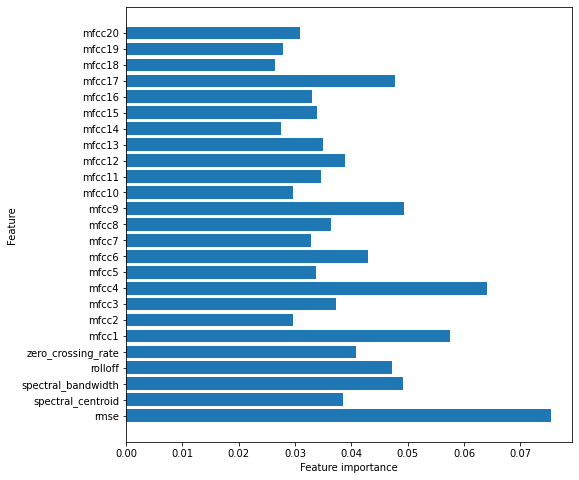

In [35]:
#Plot the chart
plot_feature_importances(forest)

In [36]:
# Based on the observation above evaluate feature selection 
from sklearn.model_selection import GridSearchCV
parameters= { 'criterion':('gini','entropy'),
              'max_depth':(3,5,7,9,10),
              'max_features':('auto', 'sqrt'),
              'min_samples_leaf': (1, 2, 4),
             'min_samples_split':(2,4,6),
              'bootstrap' :(True, False),
             'n_estimators':(100,130,150) 
            }
forest_grid= GridSearchCV(RandomForestClassifier(n_jobs=2, oob_score=False), param_grid= parameters,cv= 3, verbose= True)

In [37]:
forest_grid_model= forest_grid.fit(X_train_std, y_train_std)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 3240 out of 3240 | elapsed: 30.0min finished


In [38]:
forest_grid_model.best_estimator_

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [39]:
print("Score after Random forest parameter optimised ")
forest_grid_model.best_score_

Score after Random forest parameter optimised 


0.5960000000000001

In [40]:
# Viewing the probabilities of of the first 50 observations
forest.predict_proba(X_test_std)[0:50]
#there are 10 leaves at the end
#the numbers represent the votes obtained for each label at that leaf level

array([[0.01, 0.01, 0.  , 0.03, 0.08, 0.02, 0.78, 0.  , 0.02, 0.05],
       [0.03, 0.  , 0.24, 0.06, 0.22, 0.02, 0.02, 0.18, 0.18, 0.05],
       [0.33, 0.05, 0.17, 0.03, 0.06, 0.2 , 0.01, 0.  , 0.07, 0.08],
       [0.07, 0.35, 0.07, 0.02, 0.1 , 0.23, 0.06, 0.  , 0.05, 0.05],
       [0.  , 0.  , 0.03, 0.1 , 0.11, 0.27, 0.  , 0.25, 0.18, 0.06],
       [0.  , 0.  , 0.06, 0.08, 0.12, 0.06, 0.01, 0.6 , 0.06, 0.01],
       [0.06, 0.  , 0.01, 0.06, 0.12, 0.  , 0.73, 0.  , 0.01, 0.01],
       [0.  , 0.  , 0.03, 0.13, 0.2 , 0.04, 0.  , 0.47, 0.08, 0.05],
       [0.05, 0.01, 0.08, 0.33, 0.36, 0.02, 0.04, 0.01, 0.05, 0.05],
       [0.12, 0.01, 0.01, 0.08, 0.41, 0.01, 0.31, 0.  , 0.01, 0.04],
       [0.02, 0.74, 0.07, 0.01, 0.  , 0.13, 0.  , 0.  , 0.02, 0.01],
       [0.01, 0.01, 0.06, 0.04, 0.45, 0.  , 0.03, 0.03, 0.32, 0.05],
       [0.  , 0.  , 0.04, 0.02, 0.13, 0.  , 0.  , 0.06, 0.75, 0.  ],
       [0.09, 0.3 , 0.16, 0.  , 0.02, 0.35, 0.01, 0.  , 0.01, 0.06],
       [0.12, 0.68, 0.08, 0.  , 0.

In [41]:
#Predict and print the report for prediction
pred = forest.predict(X_test_std)
print("Classification Report")
print(classification_report(y_test_std, pred))

Classification Report
              precision    recall  f1-score   support

       blues       0.81      0.57      0.67        30
   classical       0.97      0.85      0.90        33
     country       0.52      0.52      0.52        23
       disco       0.25      0.35      0.29        17
      hiphop       0.61      0.54      0.57        26
        jazz       0.48      0.67      0.56        21
       metal       0.70      0.70      0.70        27
         pop       0.84      0.78      0.81        27
      reggae       0.67      0.53      0.59        30
        rock       0.28      0.44      0.34        16

    accuracy                           0.62       250
   macro avg       0.61      0.59      0.60       250
weighted avg       0.66      0.62      0.63       250



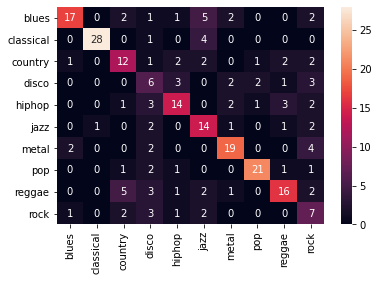

In [42]:
#Display confusion matrix 
#labels= {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
predicted= forest.predict(X_test_std)
#y, data_label= pd.factorize( labels)
cm = pd.DataFrame(confusion_matrix(y_test_std, predicted), columns=data_label, index=data_label)
sns.heatmap(cm, annot=True)

In [43]:
from sklearn.model_selection import train_test_split
GENRES=['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
number_of_rows,number_of_cols = data.shape
data_set_values=numpy.array(data)

train, test = train_test_split(data_set_values, test_size = 0.85,random_state=2,
                              stratify=data_set_values[:,number_of_cols-1])

train_x=train[:,:number_of_cols-1]
train_y=train[:,number_of_cols-1]

test_x=test[:,:number_of_cols-1]
test_y=test[:,number_of_cols-1]

print("Training data size: {}".format(train.shape))
print("Test data size: {}".format(test.shape))

Training data size: (150, 27)
Test data size: (850, 27)


In [44]:
data_new = data.replace({'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9})

In [ ]:
data_new.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.349943,0.130225,1784.420446,2002.650192,3806.485316,0.083066,-113.596748,121.557297,-19.158825,42.351032,-6.376458,18.618876,-13.697911,15.344631,-12.285267,10.980492,-8.324325,8.810669,-3.667368,5.751691,-5.162763,0.750948,-1.691938,-0.409953,-2.300209,1.219929,0
1,0.340983,0.130225,1529.835316,2038.617579,3548.820207,0.056044,-207.556793,124.006722,8.930560,35.874687,2.916037,21.523726,-8.554704,23.358671,-10.103617,11.903745,-5.560388,5.376803,-2.239120,4.216963,-6.012273,0.936110,-0.716537,0.293876,-0.287431,0.531573,0
2,0.363603,0.095918,1552.481958,1747.165985,3040.514948,0.076301,-90.754387,140.459900,-29.109968,31.689013,-13.987036,25.754759,-13.649585,11.629271,-11.780589,9.706442,-13.123111,5.789265,-8.905224,-1.083720,-9.218359,2.455806,-7.726901,-1.815723,-3.433434,-2.226821,0
3,0.404779,0.175573,1070.119953,1596.333948,2185.028454,0.033309,-199.431152,150.099213,5.647593,26.871927,1.754462,14.238345,-4.830883,9.297966,-0.757742,8.149013,-3.196314,6.087677,-2.476421,-1.073890,-2.874778,0.780977,-3.316932,0.637982,-0.619690,-3.408233,0
4,0.308590,0.141191,1835.494603,1748.362448,3580.945013,0.101500,-160.266037,126.198807,-35.605450,22.153301,-32.489269,10.864513,-23.357929,0.503118,-11.805833,1.206805,-13.083821,-2.806384,-6.934123,-7.558618,-9.173553,-4.512165,-5.453538,-0.924161,-4.409333,-11.703781,0


In [45]:
X = data_new
y = data_new['label']

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [47]:
from sklearn.preprocessing import StandardScaler


X_scaler = StandardScaler().fit(X_train)


In [48]:
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 1, Train/Test Score: 1.000/0.760
k: 3, Train/Test Score: 0.855/0.752
k: 5, Train/Test Score: 0.828/0.760
k: 7, Train/Test Score: 0.817/0.752
k: 9, Train/Test Score: 0.801/0.740
k: 11, Train/Test Score: 0.793/0.716
k: 13, Train/Test Score: 0.788/0.676
k: 15, Train/Test Score: 0.772/0.692
k: 17, Train/Test Score: 0.771/0.688
k: 19, Train/Test Score: 0.759/0.680


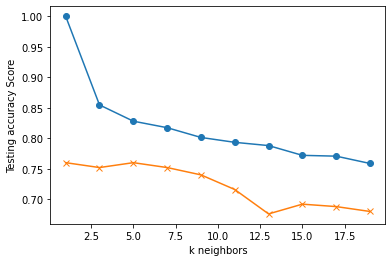

In [49]:
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [50]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train_scaled, y_train)
print('k=13 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=13 Test Acc: 0.676


k: 1, Train/Test Score: 1.000/0.732
k: 3, Train/Test Score: 0.831/0.712
k: 5, Train/Test Score: 0.803/0.732
k: 7, Train/Test Score: 0.787/0.736
k: 9, Train/Test Score: 0.772/0.712
k: 11, Train/Test Score: 0.761/0.700
k: 13, Train/Test Score: 0.763/0.704
k: 15, Train/Test Score: 0.751/0.640
k: 17, Train/Test Score: 0.741/0.648
k: 19, Train/Test Score: 0.724/0.648


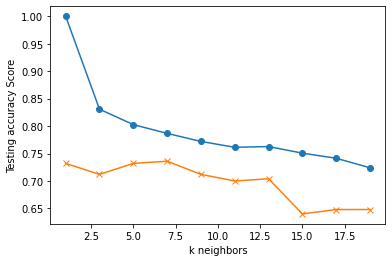

k=13 Test Acc: 0.704


In [51]:
# KNN using Robust Scalar
from sklearn.preprocessing import RobustScaler


X_scaler = RobustScaler().fit(X_train)


X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train_scaled, y_train)
print('k=13 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))


k: 1, Train/Test Score: 1.000/0.860
k: 3, Train/Test Score: 0.924/0.828
k: 5, Train/Test Score: 0.897/0.840
k: 7, Train/Test Score: 0.892/0.816
k: 9, Train/Test Score: 0.873/0.800
k: 11, Train/Test Score: 0.871/0.812
k: 13, Train/Test Score: 0.856/0.792
k: 15, Train/Test Score: 0.847/0.808
k: 17, Train/Test Score: 0.840/0.788
k: 19, Train/Test Score: 0.839/0.780


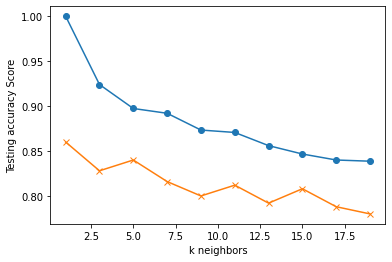

k=13 Test Acc: 0.792


In [52]:

# KNN using MinMax Scalar
# from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

# X_scaler = RobustScaler().fit(X_train)
X_scaler = MinMaxScaler().fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train_scaled, y_train)
print('k=13 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))


In [53]:
# Kmeans Cluster

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [54]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [55]:
#Use Principle Component Analysis (PCA) to reduce feature size 
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (1000, 26)
transformed shape: (1000, 2)


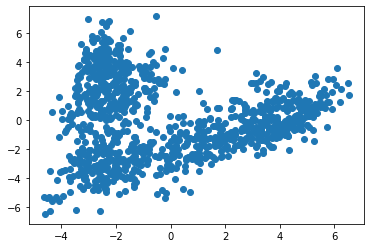

In [56]:
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

In [57]:
# Create a kmeans model using k = 10, for the 10 genres
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)

# Fit the model to the data
kmeans.fit(X_pca)

# Use the data to predict the clusters
# save the predictions as `predicted_clusters`
predicted_clusters = kmeans.predict(X_pca)

No handles with labels found to put in legend.


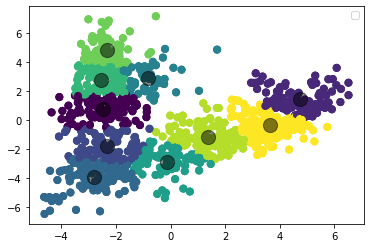

In [58]:
# Plot the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=predicted_clusters, s=50, cmap='viridis')

# Print the cluster centers and cluster labels
centers = kmeans.cluster_centers_
labels = kmeans.labels_

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.legend()
plt.show()

## Testing New Music with current Models